#### Imports

In [ ]:
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from typing import Annotated, Literal, TypeVar
import mne
import sys
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import scipy
import pywt
import pandas as pd

mne.set_log_level('WARNING')
mne.set_config('MNE_BROWSE_RAW_SIZE', '16,8')

# Define Functions

## Get Data

#### Bonn University

In [ ]:
def get_data_bonn(sets_to_read: list = ['A', 'B', 'C', 'D', 'E']):
    """
    Returns data for all specified sets from the Bonn University dataset
    Data returned is in a dictionary with set letters as keys and arrays of mne raw data

    Sets A and B are from healthy patients, while Sets C, D, and E are from epileptic patients.

    Sets C and D are seizure-free segments while set E is during a seizure.

    Each set contains 100 single-channel EEG segments of 23.6-sec duration. The EEGs were recorded at a sampling rate of 173.61 Hz with 12-bit resolution over a 10 mV range.
    """
    time_segments = 100
    time_points = 4096
    freq = 173.61

    # maps from set_letter to set_letter_alternate (for the filenames)
    sets_to_file_prefixes = {
        'A': 'Z',
        'B': 'O',
        'C': 'N',
        'D': 'F',
        'E': 'S'
    }

    raws_all_categories = {}
    for set in sets_to_read:
        if set not in sets_to_file_prefixes:
            continue

        set_letter_alternate = sets_to_file_prefixes[set]

        raws_one_set = []
        for i in range(time_segments):
            filename = f'data/bonn/SET {set}/{set_letter_alternate}{str(i+1).zfill(3)}.txt'
            z = np.loadtxt(filename)

            info = mne.create_info(
                ch_names=1,
                sfreq=freq,
                ch_types='eeg',
            )
            raw = mne.io.RawArray(
                np.reshape(z[:time_points], (1, time_points)), info)
            raws_one_set.append(raw)

        raws_all_categories[set] = raws_one_set

    return raws_all_categories

#### AHEPA

In [ ]:
def get_data_ahepa():
    """
    https://openneuro.org/datasets/ds004504/versions/1.0.7
    A dataset of EEG recordings from: Alzheimer's disease, Frontotemporal dementia and Healthy subjects
    """
    raws_all_categories = {}
    # dictionary from set to 3d numpy array (time_segments, channels, time_points)

    participants = pd.read_csv('data/AHEPA/participants.tsv', sep='\t')

    for disorder in {'F', 'C'}:
        DISORDER = participants[participants['Group'] == disorder]

        raws_one_disorder = []
        for participant_id in DISORDER['participant_id']:
            # read derivatives folder for preprocessed data
            filename = f'data/AHEPA/derivatives/{participant_id}/eeg/{participant_id}_task-eyesclosed_eeg.set'
            raw = mne.io.read_raw_eeglab(filename, preload=True)
            # raw.plot()
            raws_one_disorder.append(raw)

        raws_all_categories[disorder] = raws_one_disorder

    return raws_all_categories

## Processing

#### Filtering

In [ ]:
def filter_raws(raws_all_categories, notch_freq=50, low_freq=0.1, high_freq=64):
    for set in raws_all_categories:
        for i in range(len(raws_all_categories[set])):
            # if i > 0: break
            # raws_all_sets[set][i].copy().compute_psd().plot()

            # raws_all_sets[set][i].copy().plot(duration=5, n_channels=15, scalings=500)
            raws_all_categories[set][i] = raws_all_categories[set][i].notch_filter(
                freqs=notch_freq)
            raws_all_categories[set][i] = raws_all_categories[set][i].filter(
                l_freq=low_freq, h_freq=high_freq)
            # raws_all_sets[set][i].copy().compute_psd().plot();
            # raws_all_sets[set][i].copy().plot(duration=5, n_channels=15, scalings=500);
    return raws_all_categories

#### DWT

In [ ]:
def discrete_wavelet_transform(raws_all_categories, channel_approach: Literal['average', 'each'] = 'average'):
    dwt_outputs_all_sets = {}

    # Loop through each set we're classifying (ex: F, C or A, B, C, D, E)
    for set in raws_all_categories:
        dwt_outputs_all_sets[set] = []

        # Loop through each recording (sub-0XX)/time segment/epoch
        for epoch in raws_all_categories[set]:
            epoch_array = epoch.get_data()

            # Loop through each channel in every epoch
            for epoch in epoch_array:
                data = epoch

                if channel_approach == 'average':
                    data = np.mean(data, axis=0)
                    data = np.reshape(data, (1, data.shape[0]))

                dwt_outputs_one_epoch = []

                # Loop through each channel in the data
                for channel in data:
                    # 1D multilevel DWT
                    delta, theta, alpha, beta, gamma = pywt.wavedec(
                        channel, wavelet='db4', level=4)
                    
                    # print(delta.shape, theta.shape, alpha.shape, beta.shape, gamma.shape)
                    
                    dwt_outputs_one_epoch.append([delta, theta, alpha, beta, gamma])
                
                dwt_outputs_all_sets[set].append(dwt_outputs_one_epoch)

                # low frequencies => high time resolution, low freq resolution
                # high frequences => low time resolution, high freq resolution

                # print(cA4.shape)  # 0.1-4 Hz   delta
                # print(cD4.shape)  # 4-8 Hz     theta
                # print(cD3.shape)  # 8-16 Hz    alpha
                # print(cD2.shape)  # 16-32 Hz   beta
                # print(cD1.shape)  # 32-64 Hz   gamma
    return dwt_outputs_all_sets

## Feature Extraction

#### Features

In [ ]:
def variance(data):
    output = np.var(data)
    # print('variance_data: ', output)
    return output


def standard_deviation(data):
    """
    measures the amount of variation of a set of values
    """
    output = np.std(data)
    # print('std_data: ', output)
    return output


def kurtosis(data):
    """
    measure of the 'tailedness' of the data or outliers
    """
    # fisher = True is default, which subtracts 3 from the final value
    output = scipy.stats.kurtosis(data, fisher=False)
    # print('kurtosis output: ', output)
    return output


def nn_shannon_entropy(data):
    """
    measures the uncertainty of the data (or how surprising it is)
    """
    # squared so log is never taken of a negative number in the data
    squared = data**2
    output = np.sum(squared * np.log(squared))
    # print('entropy output: ', output)
    return output


def logarithmic_band_power(data):
    """
    """
    output = np.log(np.sum(data**2) / data.shape[0])
    # print('logarithmic band power output: ', output)
    return output


def compute_features(data):  # -> shape (#, 5)
    # print('data shape: ', data.shape)
    return np.array([
        logarithmic_band_power(data),
        standard_deviation(data),
        variance(data),
        kurtosis(data),
        nn_shannon_entropy(data)
    ], dtype=np.float64).T


BandType = Literal['A4', 'D4', 'D3', 'D2', 'D1']
FeatureType = Literal['LBP', 'Std', 'Var', 'Kur', 'SE']


def graph_feature_vectors(
    feature_vectors_all_sets: dict[str, np.ndarray],
    band_x: BandType,
    band_y: BandType,
    feature: FeatureType,
    flatten_channels=False,
    graph_individual_channels: bool = False
):
    def get_feature(
        feature_vector: np.ndarray,
        band: BandType,
        feature: FeatureType
    ) -> np.float64:

        bands = ['A4', 'D4', 'D3', 'D2', 'D1']
        features = ['LBP', 'Std', 'Var', 'Kur', 'SE']

        row = bands.index(band)
        col = features.index(feature)

        return feature_vector[
            # channel * len(bands) * len(features)
            row * len(features)
            + col
        ]

    channels = 1  # BONN ONLY

    colors = ['blue', 'green', 'yellow', 'red', 'black']
    # colors = ['blue', 'blue', 'green', 'green', 'green']

    # Loop through each available set
    for i, set in enumerate(feature_vectors_all_sets):
        # shape (# tsegments, # channels, 25)
        feature_vectors = feature_vectors_all_sets[set]

        # Loop through each time segment
        for feature_vector in feature_vectors:  # shape (# channels, 25)
            if graph_individual_channels and not flatten_channels:
                # Loop thru channels and only graph specific parts of each feature vector
                for channel in range(channels):
                    x = get_feature(
                        feature_vector[channel], band=band_x, feature=feature)
                    y = get_feature(
                        feature_vector[channel], band=band_y, feature=feature)

                    plt.scatter(x, y, color=colors[i], s=4)
            else:
                if flatten_channels:
                    x = get_feature(
                        feature_vector, band=band_x, feature=feature)
                    y = get_feature(
                        feature_vector, band=band_y, feature=feature)
                else:
                    x = get_feature(
                        feature_vector[0], band=band_x, feature=feature)
                    y = get_feature(
                        feature_vector[0], band=band_y, feature=feature)
                plt.scatter(x, y, color=colors[i], s=4)

    plt.show()

#### Feature Vector

In [ ]:
def get_feature_vectors_all_sets(dwt_outputs_all_sets):
    feature_vectors_all_sets: dict[str, np.ndarray] = {}

    # Loop through each set we're classifying (ex: F, C or A, B, C, D, E)
    for set in dwt_outputs_all_sets:
        feature_vectors_all_sets[set] = []

        # Loop through each recording (sub-0XX)/time segment
        for recording in dwt_outputs_all_sets[set]:

            feature_vectors_one_recording= []

            # Loop through each channel in the data
            for channel in recording:
                feature_vectors_one_recording.append([compute_features(band) for band in channel])
            
            feature_vectors_all_sets[set].append(feature_vectors_one_recording)

    return feature_vectors_all_sets

## Classification

# Run

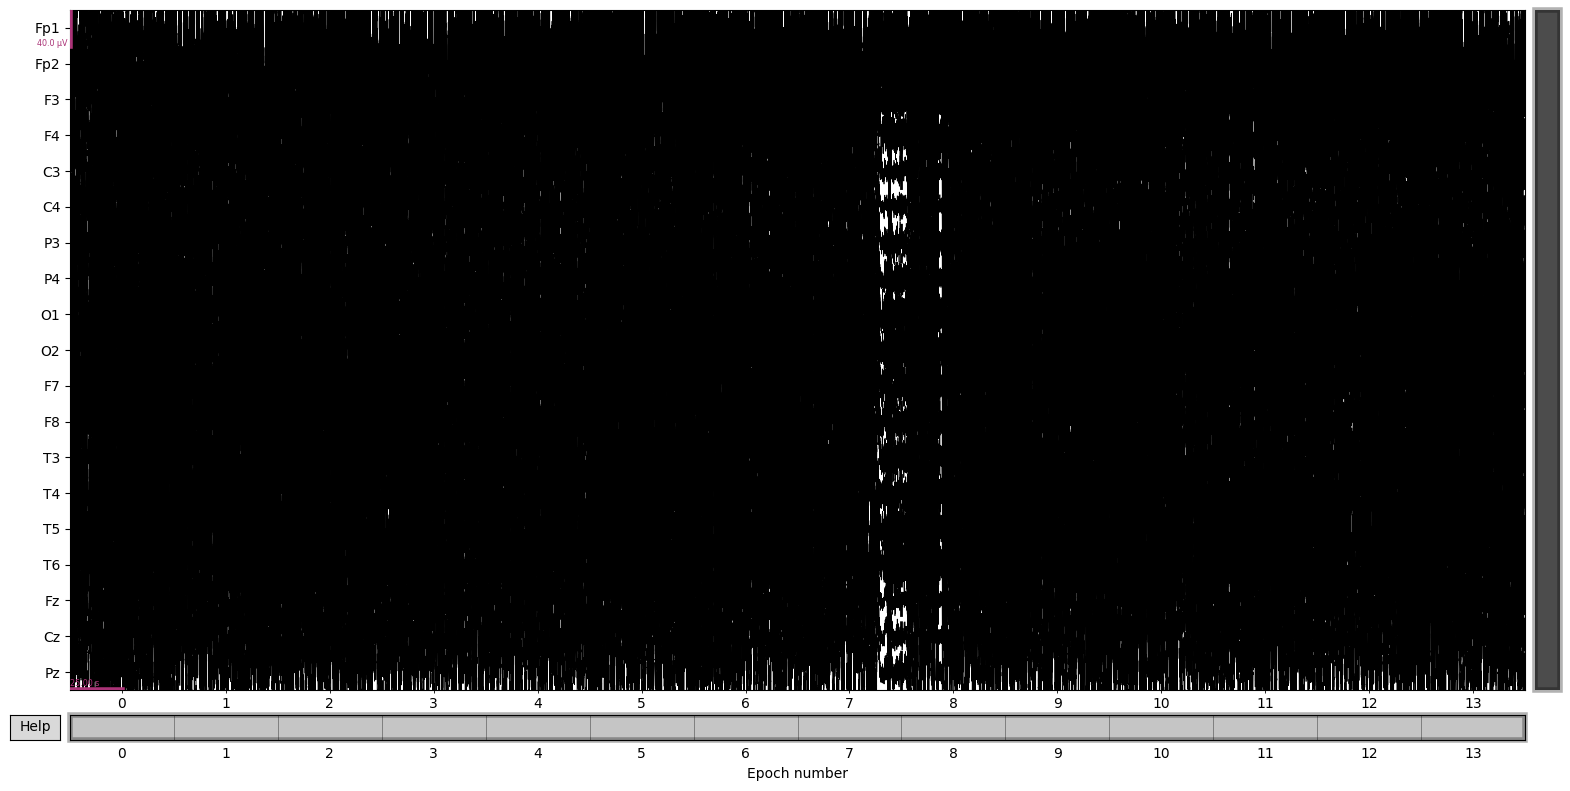

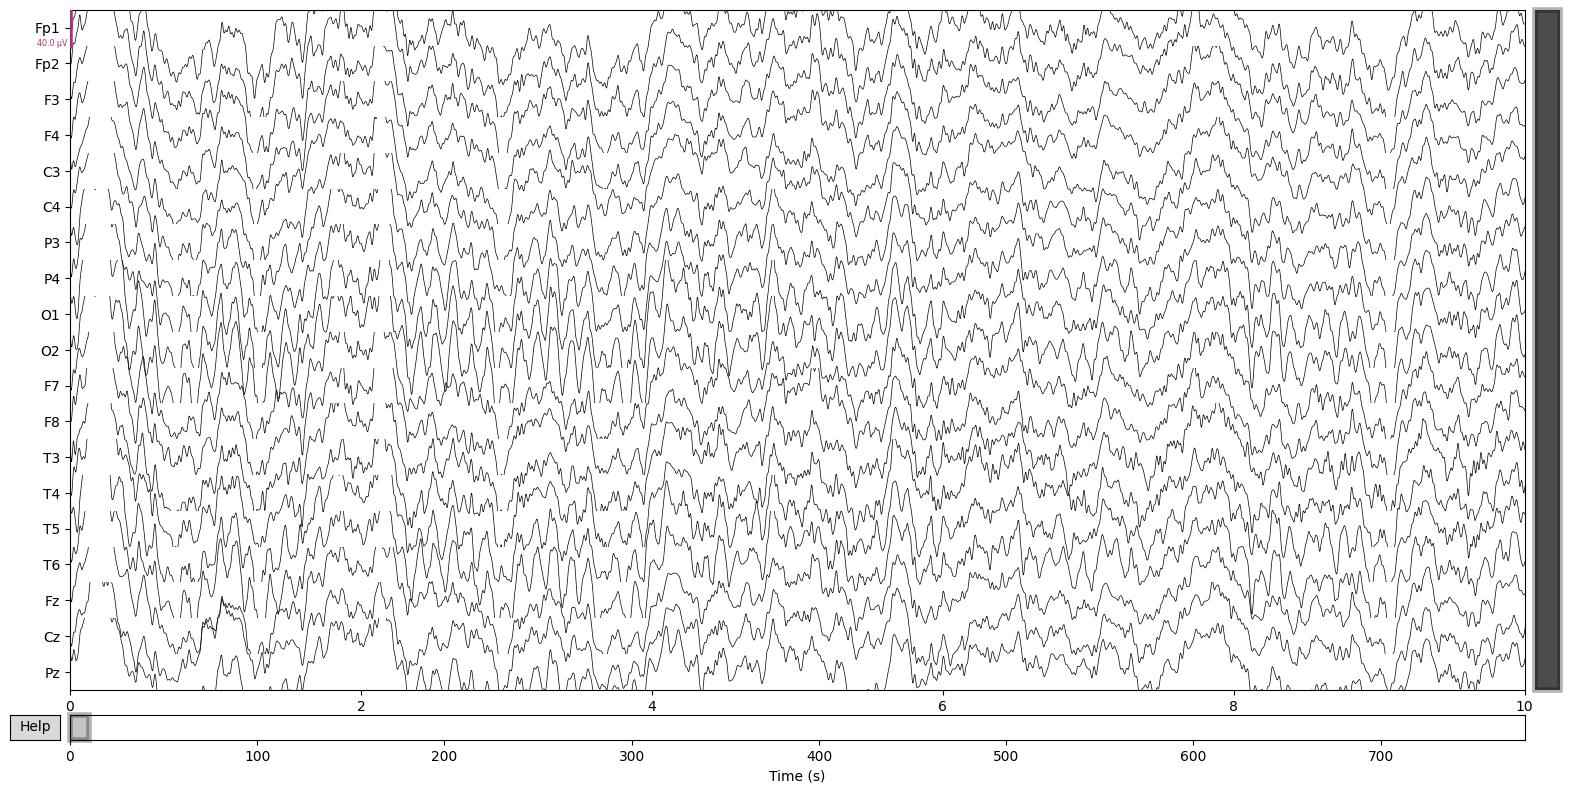

In [36]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

dataset: Literal['AHEPA', 'BONN'] = 'AHEPA'

# ------------------ AHEPA ------------------
if dataset == 'AHEPA':
    raws_all_categories = get_data_ahepa()

# ------------------ BONN ------------------
if dataset == 'BONN':
    raws_all_categories = get_data_bonn()
    raws_all_categories = filter_raws(
        raws_all_categories, notch_freq=50, low_freq=0.1, high_freq=64)

raws_all_categories['C'][0].plot();

In [ ]:
segment_length = 50
for set in raws_all_categories:
    for i, raw in enumerate(raws_all_categories[set]):
        epochs = mne.make_fixed_length_epochs(raw, duration=segment_length)
        raws_all_categories[set][i] = epochs

In [ ]:
dwt_outputs_all_sets = discrete_wavelet_transform(raws_all_categories, channel_approach='each')

print(len(dwt_outputs_all_sets['C']))          # num recordings
print(len(dwt_outputs_all_sets['C'][0]))       # num channels
print(len(dwt_outputs_all_sets['C'][0][0]))    # num freq bands
print(len(dwt_outputs_all_sets['C'][0][0][0])) # num data points

In [ ]:
feature_vectors_all_sets = get_feature_vectors_all_sets(dwt_outputs_all_sets)

print(len(feature_vectors_all_sets['C']))          # num recordings
print(len(feature_vectors_all_sets['C'][0]))       # num channels
print(len(feature_vectors_all_sets['C'][0][0]))    # num freq bands
print(len(feature_vectors_all_sets['C'][0][0][0])) # num features

In [35]:
# write feature_vectors_all_sets to csv file
import csv
for set in feature_vectors_all_sets:
    for i, recording in enumerate(feature_vectors_all_sets[set]):
        with open(f'feature_vectors/{set}/{set}_{i}_feature_vectors.csv', mode='w') as file:
            writer = csv.writer(file)
            writer.writerow([f'{f}_{b}' for b in ['delta', 'theta', 'alpha', 'beta', 'gamma'] for f in ['LBP', 'Std', 'Var', 'Kur', 'SE']])
            for channel in recording:
                writer.writerow([feature for band in channel for feature in band])